<a href="https://colab.research.google.com/github/nekeal/mwsis/blob/master/%C4%86wiczenia_obliczenia_Bayesowskie_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
import seaborn as sns
import matplotlib.pyplot as plt
tfd = tfp.distributions
import pandas as pd

In [3]:
tf.__version__, tfp.__version__

('2.8.2', '0.16.0')

# Generacja obserwacji


In [21]:
N=20000
dt = tfd.Exponential(20.).sample(N)

In [22]:
1/np.mean(dt)

20.098258518263677

# Model

$$\lambda \sim softplus(N(10,5))$$ - rozkład normalny 10, 5 przekształcony `softplusem`

$$\delta|\lambda \sim Exp(\lambda)$$ probki $\delta$ dane rozkładem wykładniczym $\lambda$
$$\lambda|\delta=?$$ - a posteriori wyznaczamy $\lambda$ na podstawie próbek $\delta$ (zmienna `dt`)

In [23]:
joint = tfd.JointDistributionNamed(dict(
    prior = tfd.TransformedDistribution(tfd.Normal(30., 5.), tfp.bijectors.Softplus()),
    delta = lambda prior:tfd.Sample(tfd.Exponential(prior), sample_shape=[N]) # losowanie delta pod warunkiem `prior`. x|y
))

In [33]:
joint.sample()


{'delta': <tf.Tensor: shape=(20000,), dtype=float32, numpy=
 array([0.02450006, 0.01039249, 0.00225871, ..., 0.03606488, 0.00149194,
        0.06113405], dtype=float32)>,
 'prior': <tf.Tensor: shape=(), dtype=float32, numpy=35.55677>}

In [34]:
def target_log_prob(Lambda):
  return joint.log_prob(prior=Lambda, delta=dt) # logarytm z prawdopodobieństwa

# MCMC

In [35]:
hmc = tfp.mcmc.NoUTurnSampler(
    target_log_prob_fn=target_log_prob,
    step_size=.1)

hmc = tfp.mcmc.TransformedTransitionKernel(
    inner_kernel=hmc,
    bijector=[
        tfp.bijectors.Softplus(),  # s1
    ])

hmc = tfp.mcmc.DualAveragingStepSizeAdaptation( # automatycznie dobiera krok,
    inner_kernel=hmc, 
    num_adaptation_steps=100,
    target_accept_prob=.8)

joint_sample = joint.sample(10)
initial_state = [
    joint_sample['prior'],
]

In [36]:
@tf.function(autograph=False, experimental_compile=True)
def run():
  return tfp.mcmc.sample_chain(
      num_results=500,
      current_state=initial_state,
      kernel=hmc,
      num_burnin_steps=100,
      trace_fn=lambda _, kr: kr)

samples, traces = run()
print('R-hat diagnostics: ', tfp.mcmc.potential_scale_reduction(samples))


R-hat diagnostics:  [<tf.Tensor: shape=(), dtype=float32, numpy=1.0015129>]


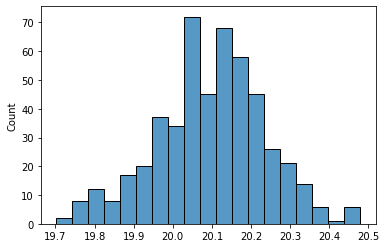

In [37]:
sns.histplot(samples[0][:,0])


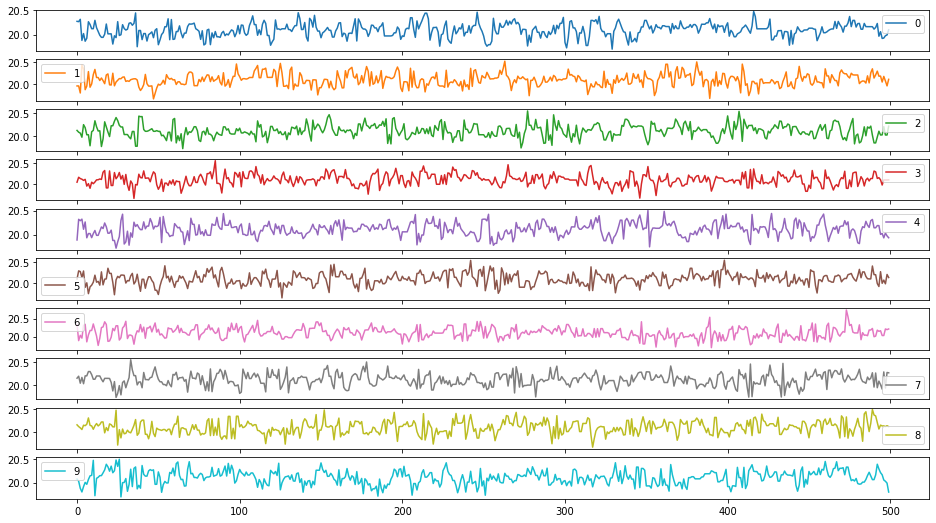

In [38]:
pd.DataFrame(samples[0].numpy()).plot(subplots=True, figsize=(16,9));


In [39]:
np.mean(samples[0], axis=0), np.std(samples[0], axis=0)

(array([20.097738, 20.091684, 20.109215, 20.102108, 20.112701, 20.105682,
        20.106733, 20.11957 , 20.099924, 20.107922], dtype=float32),
 array([0.13822043, 0.14134558, 0.13832857, 0.13301675, 0.13992152,
        0.13507453, 0.14701577, 0.1372742 , 0.141312  , 0.14777008],
       dtype=float32))

## Zadanie

Wyznaczyć rozklad sredniej zajetości systemu $M/M/1$ z $\mu=25$ dla wyestymowanego rozkladu $\lambda$

In [45]:
#TODO
mu = 25
rho = samples[0].numpy().flatten()/mu
# czym jest samples skoro możemy go podzielić przez mu, żeby dostać rho.
L = rho/(1-rho)
# sns.histplot(L)
samples[0].numpy().flatten()

# kiedy będzie przepełniony
np.mean(rho>1)

0.524

# VI

Nomalny

In [46]:
q = tfd.Normal(loc=tf.Variable(50., name='q_loc'),
                 scale=tfp.util.TransformedVariable(1., tfp.bijectors.Softplus(),
                                                    name='q_scale'))


Lub Gamma

In [16]:

# q = tfd.Gamma(concentration=tfp.util.TransformedVariable(1600., tfp.bijectors.Softplus()),
#               rate=tfp.util.TransformedVariable(160., tfp.bijectors.Softplus()))

In [47]:
losses = tfp.vi.fit_surrogate_posterior(
    target_log_prob,
    surrogate_posterior=q,
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    num_steps=5000,
    sample_size=100)
print(q.mean(), q.stddev())

tf.Tensor(20.099, shape=(), dtype=float32) tf.Tensor(0.13693249, shape=(), dtype=float32)


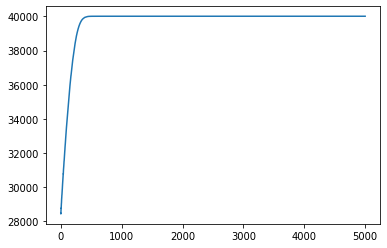

In [48]:
plt.plot(-losses)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Szymon Cader 20000, N(30,5)')

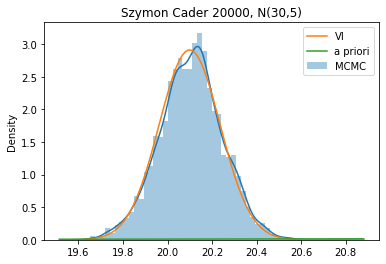

In [50]:
sns.distplot(samples[0].numpy().flatten(), label="MCMC")
x= np.linspace(*plt.xlim(), 100)
y = q.prob(x)
sns.lineplot(x,y, label="VI")
sns.lineplot(x,joint.model['prior'].prob(x), label="a priori")
plt.title('Szymon Cader 20000, N(30,5)')

~~Wnioskowanie wariacyjne jest wrażliwe na warunki poczatkowe. Zbadać dokładnosć dopasowania.~~

## Zadanie

Zabdać dopasowanie dla

a priori

- $softplus(N(20,5))$
- $softplus(N(30,5))$

i $N$

- 20
- 200
- 20000


# Zadanie

~~Zaprojektować  system kolejkowy w którym rozkład stacjonarny spełnia warunek $\pi_n\sim\frac{1}{n^4}\ n>0$ . Można zaobserwować, że symulując taki system próbkujemy liczby z rozkładu $\pi_n$ bez wyliczania stałej normalizacyjnej $\sum_{n}\pi_n$~~